# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import nygrid.nygrid as ng_grid
import nygrid.run_nygrid as ng_run
import nygrid.plots as ng_plots
import nygrid.postprocessing as ng_post

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')
print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

thermal_data_dir = os.path.join(data_dir, 'thermal')
if not os.path.exists(thermal_data_dir):
    raise FileNotFoundError('Thermal data directory not found.')

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018NewParams
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
verbose = True

# Simulation time settings
valid_days = 7
lookahead_days = 1

valid_hours = 24 * valid_days - 1
lookahead_hours = 24 * lookahead_days

In [4]:
# Read grid property file
grid_prop = ng_run.read_grid_prop(grid_data_dir)

# Read load and generation profiles
grid_profile = ng_run.read_grid_profile(grid_data_dir, start_date.year)

In [5]:
# Decrease external generation cost by 50%
change_index = grid_prop["gen_prop"]["GEN_ZONE"].isin(
    ['PJM','IESO', 'NE']).to_numpy()

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, change_index] = \
    gencost1_profile_new.loc[:, change_index] * 0.0
grid_profile['gencost1_profile'] = gencost1_profile_new

In [6]:
# # Increase NG generation costs
# change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
#     [
#         "CC_NG", 
#         "CT_NG", 
#         # "CT_FO2", 
#         # "CT_KER", 
#         # "ST_NG", 
#         # "ST_FO6", 
#         # "ST_BIT"
#         ]).to_numpy()

# gencost0_profile_new = grid_profile['gencost0_profile'].copy()
# gencost0_profile_new.loc[:, change_index] = gencost0_profile_new.loc[:, change_index] * 1.1
# grid_profile['gencost0_profile'] = gencost0_profile_new

# gencost1_profile_new = grid_profile['gencost1_profile'].copy()
# gencost1_profile_new.loc[:, change_index] = gencost1_profile_new.loc[:, change_index] * 1.1
# grid_profile['gencost1_profile'] = gencost1_profile_new

# gencost_startup_profile_new = grid_profile['gencost_startup_profile'].copy()
# gencost_startup_profile_new.loc[:, change_index] = gencost_startup_profile_new.loc[:, change_index] * 1.1
# grid_profile['gencost_startup_profile'] = gencost_startup_profile_new

In [7]:
# Increase FO2, KER and BIT generation costs
change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
    [
        # "CC_NG", 
        # "CT_NG", 
        "CT_FO2", 
        "CT_KER", 
        # "ST_NG", 
        "ST_FO6", 
        # "ST_BIT"
        ]).to_numpy()

gencost0_profile_new = grid_profile['gencost0_profile'].copy()
gencost0_profile_new.loc[:, change_index] = gencost0_profile_new.loc[:, change_index] * 0.5
grid_profile['gencost0_profile'] = gencost0_profile_new

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, change_index] = gencost1_profile_new.loc[:, change_index] * 0.5
grid_profile['gencost1_profile'] = gencost1_profile_new

gencost_startup_profile_new = grid_profile['gencost_startup_profile'].copy()
gencost_startup_profile_new.loc[:, change_index] = gencost_startup_profile_new.loc[:, change_index] * 0.5
grid_profile['gencost_startup_profile'] = gencost_startup_profile_new

In [8]:
# Decrease minimum generation levels of FO2, KER and BIT
# change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
#     ["CC_NG", "CT_NG", "CT_FO2", "CT_KER", "ST_NG", "ST_FO6", "ST_BIT"]).to_numpy()
# gen_prop_new = grid_prop['gen_prop'].copy()
# gen_prop_new.loc[change_index, 'PMIN'] = gen_prop_new.loc[change_index, 'PMIN'] * 0.1
# grid_prop['gen_prop'] = gen_prop_new

## Multi-period OPF

### Jan. 1-8, 2018

In [10]:
# Only run for one day
d = 0
start_datetime_w0 = timestamp_list[d]
end_datetime_w0 = start_datetime_w0 + timedelta(hours=valid_hours + lookahead_hours)
print(f'Start time: {start_datetime_w0}')
print(f'End time: {end_datetime_w0}')

Start time: 2018-01-01 00:00:00
End time: 2018-01-08 23:00:00


In [11]:
# Create NYGrid object
nygrid_sim_w0 = ng_grid.NYGrid(grid_prop=grid_prop,
                            start_datetime=start_datetime_w0,
                            end_datetime=end_datetime_w0,
                            verbose=verbose)

# Set load and generation time series data
nygrid_sim_w0.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_w0.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_w0.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_w0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                            grid_profile['gencost1_profile'])
nygrid_sim_w0.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_w0.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_w0.relax_external_branch_lim()

# Set generator initial condition
init_gen = np.zeros(nygrid_sim_w0.NG)
nygrid_sim_w0.set_gen_init_data(gen_init=init_gen)

# Set generator initial unit commitment condition
init_gen_commit = np.zeros(sum(grid_prop['gen_prop']['CMT_KEY'] == 1))
nygrid_sim_w0.set_gen_init_cmt_data(gen_init_cmt=init_gen_commit)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 10_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

solver_options = {
    'NodefileStart': 0.5,
    'NodefileDir': results_dir,
    'MIPGap': 1e-3
}

nygrid_sim_w0.set_options(options)

# Solve DC OPF
nygrid_sim_w0.solve_dc_opf(solver_options={'NodefileStart': 0.5})

# Get results
results_w0 = nygrid_sim_w0.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmpjsq2e3up.pyomo.lp
Reading time = 1.67 seconds
x1: 520010 rows, 507072 columns, 2485740 nonzeros
Set parameter QCPDual to value 1
Set parameter NodefileStart to value 0.5
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 520010 rows, 507072 columns and 2485740 nonzeros
Model fingerprint: 0x34a63dac
Variable types: 280512 continuous, 226560 integer (135936 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [5e-17, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-17, 1e+03]
Presolve removed 201311 rows and 142016 columns
Presolve time: 3.56s
Presolved: 318699 rows, 365056 columns, 1350637 nonzeros
Variable types: 185196 continuous, 179860 intege

In [12]:
print("s_ramp_up", results_w0['s_ramp_up'].sum())
print("s_ramp_down", results_w0['s_ramp_down'].sum())
print("s_over_gen", results_w0['s_over_gen'].sum())
print("s_load_shed", results_w0['s_load_shed'].sum())
print("s_if_max", results_w0['s_if_max'].sum())
print("s_if_min", results_w0['s_if_min'].sum())
print("s_br_max", results_w0['s_br_max'].sum())
print("s_br_min", results_w0['s_br_min'].sum())
print("s_esr_pcrg", results_w0['s_esr_pcrg'].sum())
print("s_esr_pdis", results_w0['s_esr_pdis'].sum())
print("s_esr_soc_min", results_w0['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_w0['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_w0['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_w0['s_esr_soc_undert'].sum())
print("s_min_up_time", results_w0['s_min_up_time'].sum())
print("s_min_down_time", results_w0['s_min_down_time'].sum())

s_ramp_up 2992.8950000000427
s_ramp_down 23.320010108706654
s_over_gen 0.0
s_load_shed 0.0
s_if_max 15051.322580494929
s_if_min 301017.1834401953
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7440.0
s_min_up_time 8.0
s_min_down_time 0.0


In [13]:
# import pickle
# # Save simulation nygrid_results to pickle
# filename = f'nygrid_sim_2018_jan_1-8.pkl'
# with open(os.path.join(results_dir, filename), 'wb') as f:
#     pickle.dump(results_w0, f)

In [14]:
# Only run for one day
d = d + valid_days
start_datetime_w1 = timestamp_list[d]
end_datetime_w1 = start_datetime_w1 + timedelta(hours=valid_hours + lookahead_hours)
print(f'Start time: {start_datetime_w1}')
print(f'End time: {end_datetime_w1}')

Start time: 2018-01-08 00:00:00
End time: 2018-01-15 23:00:00


In [15]:
# Create NYGrid object
nygrid_sim_w1 = ng_grid.NYGrid(grid_prop=grid_prop,
                            start_datetime=start_datetime_w1,
                            end_datetime=end_datetime_w1,
                            verbose=verbose)

# Set load and generation time series data
nygrid_sim_w1.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_w1.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_w1.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_w1.set_gen_cost_sch(grid_profile['gencost0_profile'],
                            grid_profile['gencost1_profile'])
nygrid_sim_w1.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_w1.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_w1.relax_external_branch_lim()

# Set initial conditions for the next iteration
hour_before_start = start_datetime_w1 + timedelta(hours=-1)

# Set generator initial condition
init_gen = results_w0['PG'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_w1.set_gen_init_data(gen_init=init_gen)

# Set generator initial unit commitment condition
init_gen_commit = results_w0['genCommit'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_w1.set_gen_init_cmt_data(gen_init_cmt=init_gen_commit)

# Set ESR initial condition for the next iteration
init_soc = results_w0['esrSOC'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_w1.set_esr_init_data(esr_init=init_soc)

# Calculate hours since last startup and shutdown
hour_since_last_startup = np.zeros(nygrid_sim_w0.NG_avail, dtype=int)
hour_since_last_shutdown = np.zeros(nygrid_sim_w0.NG_avail, dtype=int)

for ii in range(nygrid_sim_w0.NG_avail):
    startup_record = results_w0['genStartup'][:hour_before_start][ii]
    if startup_record.sum() > 0:
        last_startup_hour = startup_record[startup_record > 0].index[-1]
        hour_since_last_startup[ii] = int((hour_before_start - last_startup_hour).total_seconds()/ 3600)
    else:
        hour_since_last_startup[ii] = 999
    
    shutdown_record = results_w0['genShutdown'][:hour_before_start][ii]
    if shutdown_record.sum() > 0:
        last_shutdown_hour = shutdown_record[shutdown_record > 0].index[-1]
        hour_since_last_shutdown[ii] = int((hour_before_start - last_shutdown_hour).total_seconds()/3600)
    else:
        hour_since_last_shutdown[ii] = 999

nygrid_sim_w1.set_gen_last_startup_data(hour_since_last_startup)
nygrid_sim_w1.set_gen_last_shutdown_data(hour_since_last_shutdown)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed':10_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

solver_options = {
    'NodefileStart': 0.5,
    'NodefileDir': results_dir,
    'MIPGap': 1e-3
}

nygrid_sim_w1.set_options(options)

# Solve DC OPF
nygrid_sim_w1.solve_dc_opf(solver_options)

# Get results
results_w1 = nygrid_sim_w1.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmphh3x69ap.pyomo.lp
Reading time = 1.69 seconds
x1: 520059 rows, 507072 columns, 2485956 nonzeros
Set parameter QCPDual to value 1
Set parameter NodefileStart to value 0.5
Set parameter NodefileDir to value "/mnt/Bo_HDD/NYgrid-python/results"
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 520059 rows, 507072 columns and 2485956 nonzeros
Model fingerprint: 0xe314381d
Variable types: 280512 continuous, 226560 integer (135936 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [5e-17, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-17, 1e+03]
Presolve removed 201613 rows and 142638 columns
Presolve time: 3.53

In [16]:
print("s_ramp_up", results_w1['s_ramp_up'].sum())
print("s_ramp_down", results_w1['s_ramp_down'].sum())
print("s_over_gen", results_w1['s_over_gen'].sum())
print("s_load_shed", results_w1['s_load_shed'].sum())
print("s_if_max", results_w1['s_if_max'].sum())
print("s_if_min", results_w1['s_if_min'].sum())
print("s_br_max", results_w1['s_br_max'].sum())
print("s_br_min", results_w1['s_br_min'].sum())
print("s_esr_pcrg", results_w1['s_esr_pcrg'].sum())
print("s_esr_pdis", results_w1['s_esr_pdis'].sum())
print("s_esr_soc_min", results_w1['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_w1['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_w1['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_w1['s_esr_soc_undert'].sum())
print("s_min_up_time", results_w1['s_min_up_time'].sum())
print("s_min_down_time", results_w1['s_min_down_time'].sum())

s_ramp_up 15.220000000012636
s_ramp_down 23.100003234787525
s_over_gen 0.0
s_load_shed 0.0
s_if_max 87211.98534333432
s_if_min 320427.2263990809
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7440.0
s_min_up_time 7.0
s_min_down_time 0.0


### Jul. 2-9, 2018

In [17]:
# Only run for one day
d = 182
start_datetime_s0 = timestamp_list[d]
end_datetime_s0 = start_datetime_s0 + timedelta(hours=valid_hours + lookahead_hours)
print(f'Start time: {start_datetime_s0}')
print(f'End time: {end_datetime_s0}')

Start time: 2018-07-02 00:00:00
End time: 2018-07-09 23:00:00


In [18]:
# Create NYGrid object
nygrid_sim_s0 = ng_grid.NYGrid(grid_prop=grid_prop,
                            start_datetime=start_datetime_s0,
                            end_datetime=end_datetime_s0,
                            verbose=verbose)

# Set load and generation time series data
nygrid_sim_s0.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_s0.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_s0.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_s0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                            grid_profile['gencost1_profile'])
nygrid_sim_s0.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_s0.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_s0.relax_external_branch_lim()

# Set generator initial condition
init_gen = np.zeros(nygrid_sim_s0.NG)
nygrid_sim_s0.set_gen_init_data(gen_init=init_gen)

# Set generator initial unit commitment condition
init_gen_commit = np.zeros(nygrid_sim_s0.NG_avail)
nygrid_sim_s0.set_gen_init_cmt_data(gen_init_cmt=init_gen_commit)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 10_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

solver_options = {
    'NodefileStart': 0.5,
    'NodefileDir': results_dir,
    'MIPGap': 1e-3
}

nygrid_sim_s0.set_options(options)

# Solve DC OPF
nygrid_sim_s0.solve_dc_opf(solver_options)

# Get results
results_s0 = nygrid_sim_s0.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmpdmlxcprn.pyomo.lp
Reading time = 1.68 seconds
x1: 520010 rows, 507072 columns, 2485740 nonzeros
Set parameter QCPDual to value 1
Set parameter NodefileStart to value 0.5
Set parameter NodefileDir to value "/mnt/Bo_HDD/NYgrid-python/results"
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 520010 rows, 507072 columns and 2485740 nonzeros
Model fingerprint: 0x1b20a279
Variable types: 280512 continuous, 226560 integer (135936 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [4e-17, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-18, 1e+03]
Presolve removed 202237 rows and 145880 columns
Presolve time: 3.46

In [19]:
print("s_ramp_up", results_s0['s_ramp_up'].sum())
print("s_ramp_down", results_s0['s_ramp_down'].sum())
print("s_over_gen", results_s0['s_over_gen'].sum())
print("s_load_shed", results_s0['s_load_shed'].sum())
print("s_if_max", results_s0['s_if_max'].sum())
print("s_if_min", results_s0['s_if_min'].sum())
print("s_br_max", results_s0['s_br_max'].sum())
print("s_br_min", results_s0['s_br_min'].sum())
print("s_esr_pcrg", results_s0['s_esr_pcrg'].sum())
print("s_esr_pdis", results_s0['s_esr_pdis'].sum())
print("s_esr_soc_min", results_s0['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_s0['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_s0['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_s0['s_esr_soc_undert'].sum())
print("s_min_up_time", results_s0['s_min_up_time'].sum())
print("s_min_down_time", results_s0['s_min_down_time'].sum())

s_ramp_up 3110.2550000000083
s_ramp_down 126.080000000001
s_over_gen 0.0
s_load_shed 0.0
s_if_max 42482.4814069682
s_if_min 408576.92273175827
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7440.0
s_min_up_time 0.0
s_min_down_time 0.0


In [20]:
# import pickle
# # Save simulation nygrid_results to pickle
# filename = f'nygrid_sim_2018_jul_2-9.pkl'
# with open(os.path.join(results_dir, filename), 'wb') as f:
#     pickle.dump(results_0, f)

In [21]:
# Only run for one day
d = d + valid_days
start_datetime_s1= timestamp_list[d]
end_datetime_s1 = start_datetime_s1 + timedelta(hours=valid_hours + lookahead_hours)
print(f'Start time: {start_datetime_s1}')
print(f'End time: {end_datetime_s1}')

Start time: 2018-07-09 00:00:00
End time: 2018-07-16 23:00:00


In [22]:
# Create NYGrid object
nygrid_sim_s1 = ng_grid.NYGrid(grid_prop=grid_prop,
                            start_datetime=start_datetime_s1,
                            end_datetime=end_datetime_s1,
                            verbose=verbose)

# Set load and generation time series data
nygrid_sim_s1.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_s1.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_s1.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_s1.set_gen_cost_sch(grid_profile['gencost0_profile'],
                            grid_profile['gencost1_profile'])
nygrid_sim_s1.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_s1.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_s1.relax_external_branch_lim()

# Set initial conditions for the next iteration
hour_before_start = start_datetime_s1 + timedelta(hours=-1)

# Set generator initial condition
init_gen = results_s0['PG'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_s1.set_gen_init_data(gen_init=init_gen)

# Set generator initial unit commitment condition
init_gen_commit = results_s0['genCommit'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_s1.set_gen_init_cmt_data(gen_init_cmt=init_gen_commit)

# Set ESR initial condition for the next iteration
init_soc = results_s0['esrSOC'].loc[hour_before_start].to_numpy().squeeze()
nygrid_sim_s1.set_esr_init_data(esr_init=init_soc)

# Calculate hours since last startup and shutdown
for ii in range(nygrid_sim_s0.NG_avail):
    startup_record = results_s0['genStartup'][:hour_before_start][ii]
    if startup_record.sum() > 0:
        last_startup_hour = startup_record[startup_record > 0].index[-1]
        hour_since_last_startup[ii] = int((hour_before_start - last_startup_hour).total_seconds()/ 3600)
    else:
        hour_since_last_startup[ii] = 999
    
    shutdown_record = results_s0['genShutdown'][:hour_before_start][ii]
    if shutdown_record.sum() > 0:
        last_shutdown_hour = shutdown_record[shutdown_record > 0].index[-1]
        hour_since_last_shutdown[ii] = int((hour_before_start - last_shutdown_hour).total_seconds()/3600)
    else:
        hour_since_last_shutdown[ii] = 999

nygrid_sim_s1.set_gen_last_startup_data(hour_since_last_startup)
nygrid_sim_s1.set_gen_last_shutdown_data(hour_since_last_shutdown)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 10_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

solver_options = {
    'NodefileStart': 0.5,
    'NodefileDir': results_dir,
    'MIPGap': 1e-3
}

nygrid_sim_s1.set_options(options)

# Solve DC OPF
nygrid_sim_s1.solve_dc_opf(solver_options)

# Get results
results_s1 = nygrid_sim_s1.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmpgy8b4ai9.pyomo.lp
Reading time = 1.67 seconds
x1: 520044 rows, 507072 columns, 2485875 nonzeros
Set parameter QCPDual to value 1
Set parameter NodefileStart to value 0.5
Set parameter NodefileDir to value "/mnt/Bo_HDD/NYgrid-python/results"
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 520044 rows, 507072 columns and 2485875 nonzeros
Model fingerprint: 0x0b40e4a0
Variable types: 280512 continuous, 226560 integer (135936 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [4e-17, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-17, 1e+03]
Presolve removed 202466 rows and 146035 columns
Presolve time: 3.46

In [23]:
print("s_ramp_up", results_s1['s_ramp_up'].sum())
print("s_ramp_down", results_s1['s_ramp_down'].sum())
print("s_over_gen", results_s1['s_over_gen'].sum())
print("s_load_shed", results_s1['s_load_shed'].sum())
print("s_if_max", results_s1['s_if_max'].sum())
print("s_if_min", results_s1['s_if_min'].sum())
print("s_br_max", results_s1['s_br_max'].sum())
print("s_br_min", results_s1['s_br_min'].sum())
print("s_esr_pcrg", results_s1['s_esr_pcrg'].sum())
print("s_esr_pdis", results_s1['s_esr_pdis'].sum())
print("s_esr_soc_min", results_s1['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_s1['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_s1['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_s1['s_esr_soc_undert'].sum())
print("s_min_up_time", results_s1['s_min_up_time'].sum())
print("s_min_down_time", results_s1['s_min_down_time'].sum())

s_ramp_up 146.7800000000051
s_ramp_down 84.40000000000313
s_over_gen 0.0
s_load_shed 0.0
s_if_max 39642.9208408298
s_if_min 355685.6407011455
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7440.0
s_min_up_time 2.0
s_min_down_time 3.0


## Process the results

### Read CEMS data

In [24]:
gen_combiner = pd.read_excel(os.path.join(thermal_data_dir, '2018_nyca_thermal.xlsx'),
                             sheet_name='matched_with_id_filtered')
gen_combiner = gen_combiner.rename(columns={
    '   Station        Unit': 'NYISO_Name',
})

# Map unit type GT, JE to CT
gen_combiner['Unit Type'] = gen_combiner['Unit Type'].replace(
    {'GT': 'CT', 'JE': 'CT'})
gen_combiner['Fuel Type Secondary'] = gen_combiner['Fuel Type Secondary'].astype(
    str).replace({'nan': ''})

gen_combiner['GEN_NAME'] = gen_combiner['NYISO_Name'] + gen_combiner['ID']
gen_combiner

,NYISO_Name,Zone,PTID,Name Plate Rating (MW),Dual Fuel,Unit Type,Fuel Type Primary,Fuel Type Secondary,2017 Net Energy (GWh),Note,...,CAMD_Unit_ID,CAMD_Generator_ID,CAMD_Nameplate_Capacity,CAMD_Fuel_Type,EIA_Latitude,EIA_Longitude,ID,eco_min_ratio_obs,gen_bus,GEN_NAME
0,Danskammer 1,G,23586,72.0,YES,ST,NG,FO6,0.93040,NaN,...,1,1,72.0,Pipeline Natural Gas,41.571247,-73.974981,"(2480,1)",0.50,77,"Danskammer 1(2480,1)"
1,Danskammer 2,G,23589,73.5,YES,ST,NG,FO6,0.90830,NaN,...,2,2,73.5,Pipeline Natural Gas,41.571247,-73.974981,"(2480,2)",0.50,77,"Danskammer 2(2480,2)"
2,Danskammer 3,G,23590,147.1,NaN,ST,NG,,2.06448,NaN,...,3,3,147.1,Pipeline Natural Gas,41.571247,-73.974981,"(2480,3)",0.50,77,"Danskammer 3(2480,3)"
3,Danskammer 4,G,23591,239.4,NaN,ST,NG,,5.05390,NaN,...,4,4,239.4,Pipeline Natural Gas,41.571247,-73.974981,"(2480,4)",0.50,77,"Danskammer 4(2480,4)"
4,Arthur Kill ST 2,J,23512,376.2,NaN,ST,NG,,563.62800,NaN,...,20,2,376.2,Pipeline Natural Gas,40.591564,-74.200035,"(2490,20)",0.28,82,"Arthur Kill ST 2(2490,20)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Bayonne EC CTG4,J,323685,64.0,YES,CT,NG,KER,67.92100,NJ,...,GT4,GT4,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT4)",0.80,81,"Bayonne EC CTG4(56964,GT4)"
232,Bayonne EC CTG5,J,323686,64.0,YES,CT,NG,KER,89.64800,NJ,...,GT5,GT5,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT5)",0.80,81,"Bayonne EC CTG5(56964,GT5)"
233,Bayonne EC CTG6,J,323687,64.0,YES,CT,NG,KER,72.82700,NJ,...,GT6,GT6,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT6)",0.80,81,"Bayonne EC CTG6(56964,GT6)"
234,Bayonne EC CTG7,J,323688,64.0,YES,CT,NG,KER,83.81700,NJ,...,GT7,GT7,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT7)",0.80,81,"Bayonne EC CTG7(56964,GT7)"


In [25]:
cems_data_dir = os.path.join(thermal_data_dir, 'cems_2018')
df_list = list()
for mo in range(1, 13):
    df = pd.read_csv(os.path.join(cems_data_dir, f'2018ny{str(mo).zfill(2)}.csv'),
                     low_memory=False)
    df_list.append(df)

# Concatenate all the dataframes
cems_df = pd.concat(df_list, axis=0, ignore_index=True)

# Rename columns
cems_df = cems_df.rename(columns={
    'ORISPL_CODE': 'Plant_ID',
    'UNITID': 'Unit_ID',
})

# Add time columns from OP_DATE and OP_HOUR
cems_df['Time'] = pd.to_datetime(
    cems_df['OP_DATE']) + pd.to_timedelta(cems_df['OP_HOUR'], unit='h')
# cems_df['Month'] = cems_df['Time'].dt.month

# Drop columns that are not needed
cems_df = cems_df.drop(columns=['STATE', 'FAC_ID', 'UNIT_ID', 'OP_DATE', 'OP_HOUR',
                                'SO2_MASS_MEASURE_FLG', 'SO2_RATE_MEASURE_FLG',
                                'NOX_MASS_MEASURE_FLG', 'NOX_RATE_MEASURE_FLG',
                                'CO2_MASS_MEASURE_FLG', 'CO2_RATE_MEASURE_FLG',
                                'SLOAD (1000lb/hr)'])

In [26]:
cems_gload = dict()
cems_heat_input = dict()

for ii in range(gen_combiner.shape[0]):

    gen_info = gen_combiner.iloc[ii]

    unit_df = cems_df[(cems_df['Plant_ID'] == gen_info['CAMD_Plant_ID'])
                        & (cems_df['Unit_ID'] == gen_info['CAMD_Unit_ID'])]
    unit_df = unit_df.set_index('Time').sort_index()
    
    cems_gload[gen_info['GEN_NAME']] = unit_df['GLOAD (MW)']
    # cems_heat_input[gen_info['GEN_NAME']] = unit_df['HEAT_INPUT (mmBtu)']

# Create a dataframe from the dictionary
cems_gload_df = pd.DataFrame(cems_gload)
# cems_heat_input_df = pd.DataFrame(cems_heat_input)

# Subset the data to the time range of the simulation
cems_gload_df_w0 = cems_gload_df.loc[start_datetime_w0:end_datetime_w0]
cems_gload_df_w1 = cems_gload_df.loc[start_datetime_w1:end_datetime_w1]
cems_gload_df_s0 = cems_gload_df.loc[start_datetime_s0:end_datetime_s0]
cems_gload_df_s1 = cems_gload_df.loc[start_datetime_s1:end_datetime_s1]

In [27]:
gen_fuel = gen_combiner[['GEN_NAME','Unit Type', 'Fuel Type Primary']].copy()
gen_fuel['GEN_FUEL'] = gen_fuel['Unit Type'] + '_' + gen_fuel['Fuel Type Primary']
gen_fuel_dict = gen_fuel.set_index('GEN_NAME')['GEN_FUEL'].to_dict()

# GlOAD grouped by unit type and fuel type
cems_gload_summary_w0 = cems_gload_df_w0.groupby(gen_fuel_dict, axis=1).sum()
cems_gload_summary_w1 = cems_gload_df_w1.groupby(gen_fuel_dict, axis=1).sum()
cems_gload_summary_s0 = cems_gload_df_s0.groupby(gen_fuel_dict, axis=1).sum()
cems_gload_summary_s1 = cems_gload_df_s1.groupby(gen_fuel_dict, axis=1).sum()

### Power dispatch

In [28]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_w0 = ng_post.get_pg_by_fuel(results_w0, nygrid_sim_w0,
                                              valid_hours=nygrid_sim_w0.NT)

# Drop NJ generators
cols_drop_cc_ng = [col for col in pg_by_fuel_dict_w0['CC_NG'].columns if '50006' in col]
pg_by_fuel_dict_w0['CC_NG'] = pg_by_fuel_dict_w0['CC_NG'].drop(columns=cols_drop_cc_ng)

cols_drop_ct_ng = [col for col in pg_by_fuel_dict_w0['CT_NG'].columns if '56964' in col]
pg_by_fuel_dict_w0['CT_NG'] = pg_by_fuel_dict_w0['CT_NG'].drop(columns=cols_drop_ct_ng)

# 2018 Baseline
pg_by_fuel_sum_w0 = dict()
for fuel_type, pg_by_fuel in pg_by_fuel_dict_w0.items():
    pg_by_fuel_sum_w0[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_w0 = pd.DataFrame(pg_by_fuel_sum_w0,
                                   index=pg_by_fuel_dict_w0['CC_NG'].index)


In [29]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_w1 = ng_post.get_pg_by_fuel(results_w1, nygrid_sim_w1,
                                              valid_hours=nygrid_sim_w1.NT)

# Drop NJ generators
cols_drop_cc_ng = [col for col in pg_by_fuel_dict_w1['CC_NG'].columns if '50006' in col]
pg_by_fuel_dict_w1['CC_NG'] = pg_by_fuel_dict_w1['CC_NG'].drop(columns=cols_drop_cc_ng)

cols_drop_ct_ng = [col for col in pg_by_fuel_dict_w1['CT_NG'].columns if '56964' in col]
pg_by_fuel_dict_w1['CT_NG'] = pg_by_fuel_dict_w1['CT_NG'].drop(columns=cols_drop_ct_ng)

# 2018 Baseline
pg_by_fuel_sum_w1 = dict()
for fuel_type, pg_by_fuel in pg_by_fuel_dict_w1.items():
    pg_by_fuel_sum_w1[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_w1 = pd.DataFrame(pg_by_fuel_sum_w1,
                                   index=pg_by_fuel_dict_w1['CC_NG'].index)


In [30]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_s0 = ng_post.get_pg_by_fuel(results_s0, nygrid_sim_s0,
                                           valid_hours=nygrid_sim_s0.NT)

# Drop NJ generators
cols_drop_cc_ng = [col for col in pg_by_fuel_dict_s0['CC_NG'].columns if '50006' in col]
pg_by_fuel_dict_s0['CC_NG'] = pg_by_fuel_dict_s0['CC_NG'].drop(columns=cols_drop_cc_ng)

cols_drop_ct_ng = [col for col in pg_by_fuel_dict_s0['CT_NG'].columns if '56964' in col]
pg_by_fuel_dict_s0['CT_NG'] = pg_by_fuel_dict_s0['CT_NG'].drop(columns=cols_drop_ct_ng)

# 2018 Baseline
pg_by_fuel_sum_s0 = dict()
for fuel_type, pg_by_fuel in pg_by_fuel_dict_s0.items():
    pg_by_fuel_sum_s0[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_s0 = pd.DataFrame(pg_by_fuel_sum_s0,
                                   index=pg_by_fuel_dict_s0['CC_NG'].index)

In [31]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_s1 = ng_post.get_pg_by_fuel(results_s1, nygrid_sim_s1,
                                           valid_hours=nygrid_sim_s0.NT)

# Drop NJ generators
cols_drop_cc_ng = [col for col in pg_by_fuel_dict_s1['CC_NG'].columns if '50006' in col]
pg_by_fuel_dict_s1['CC_NG'] = pg_by_fuel_dict_s1['CC_NG'].drop(columns=cols_drop_cc_ng)

cols_drop_ct_ng = [col for col in pg_by_fuel_dict_s1['CT_NG'].columns if '56964' in col]
pg_by_fuel_dict_s1['CT_NG'] = pg_by_fuel_dict_s1['CT_NG'].drop(columns=cols_drop_ct_ng)

# 2018 Baseline
pg_by_fuel_sum_s1 = dict()
for fuel_type, pg_by_fuel in pg_by_fuel_dict_s1.items():
    pg_by_fuel_sum_s1[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_s1 = pd.DataFrame(pg_by_fuel_sum_s1,
                                   index=pg_by_fuel_dict_s1['CC_NG'].index)

In [32]:
# External bus load profile
bus_prop = nygrid_sim_w0.grid_prop['bus_prop']
bus_zone_dict = bus_prop.set_index('BUS_I')['BUS_ZONE'].to_dict()

load_profile_by_zone_2018 = grid_profile['load_profile'].groupby(bus_zone_dict, axis=1).sum()

load_profile_external = load_profile_by_zone_2018[['NE','PJM','IESO']]
load_profile_external_sum = load_profile_external.sum(axis=1)

load_profile_external_sum_w0 = load_profile_external_sum.loc[start_datetime_w0:end_datetime_w0]
load_profile_external_sum_w1 = load_profile_external_sum.loc[start_datetime_w1:end_datetime_w1]
load_profile_external_sum_s0 = load_profile_external_sum.loc[start_datetime_s0:end_datetime_s0]
load_profile_external_sum_s1 = load_profile_external_sum.loc[start_datetime_s1:end_datetime_s1]

net_import_w0 = pg_by_fuel_sum_w0['Import_Import'] - load_profile_external_sum_w0
net_import_w1 = pg_by_fuel_sum_w1['Import_Import'] - load_profile_external_sum_w1
net_import_s0 = pg_by_fuel_sum_s0['Import_Import'] - load_profile_external_sum_s0
net_import_s1 = pg_by_fuel_sum_s1['Import_Import'] - load_profile_external_sum_s1

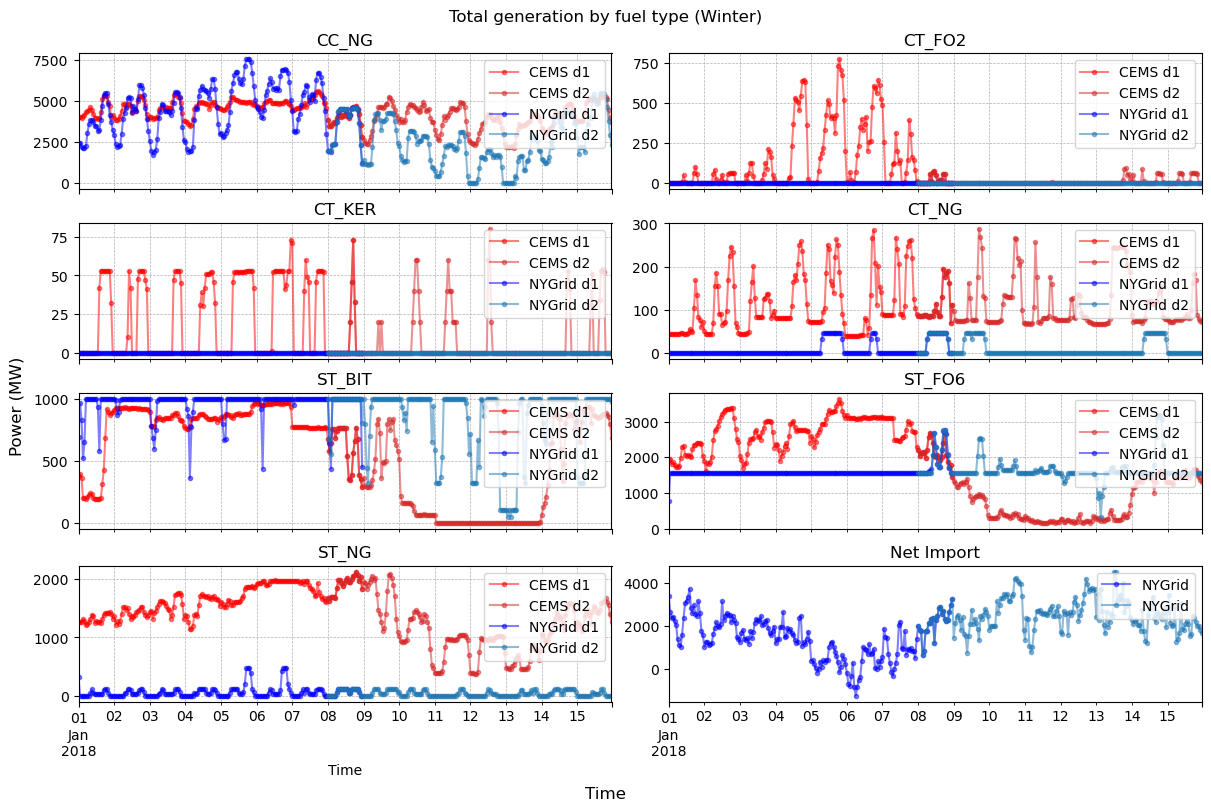

In [33]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8), sharex=True,
                        layout='constrained')

for i, fuel_type in enumerate(cems_gload_summary_w0.columns):
    ax = axs.flatten()[i]
    cems_gload_summary_w0[fuel_type].plot(ax=ax, alpha=0.5, color='red',
                                          label='CEMS d1', marker='.')
    cems_gload_summary_w1[fuel_type].plot(ax=ax, alpha=0.5, color='tab:red',
                                          label='CEMS d2', marker='.')
    pg_by_fuel_sum_w0[fuel_type].plot(ax=ax, alpha=0.5, color='blue',
                                      label='NYGrid d1', marker='.')
    pg_by_fuel_sum_w1[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue',
                                      label='NYGrid d2', marker='.')

    ax.set_title(fuel_type)
    ax.legend(loc='upper right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax = axs.flatten()[-1]
net_import_w0.plot(ax=ax, alpha=0.5, color='blue',
                   label='NYGrid', marker='.')
net_import_w1.plot(ax=ax, alpha=0.5, color='tab:blue',
                   label='NYGrid', marker='.')
ax.set_title('Net Import')
ax.legend(loc='upper right')

fig.supxlabel('Time')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type (Winter)')
plt.show()

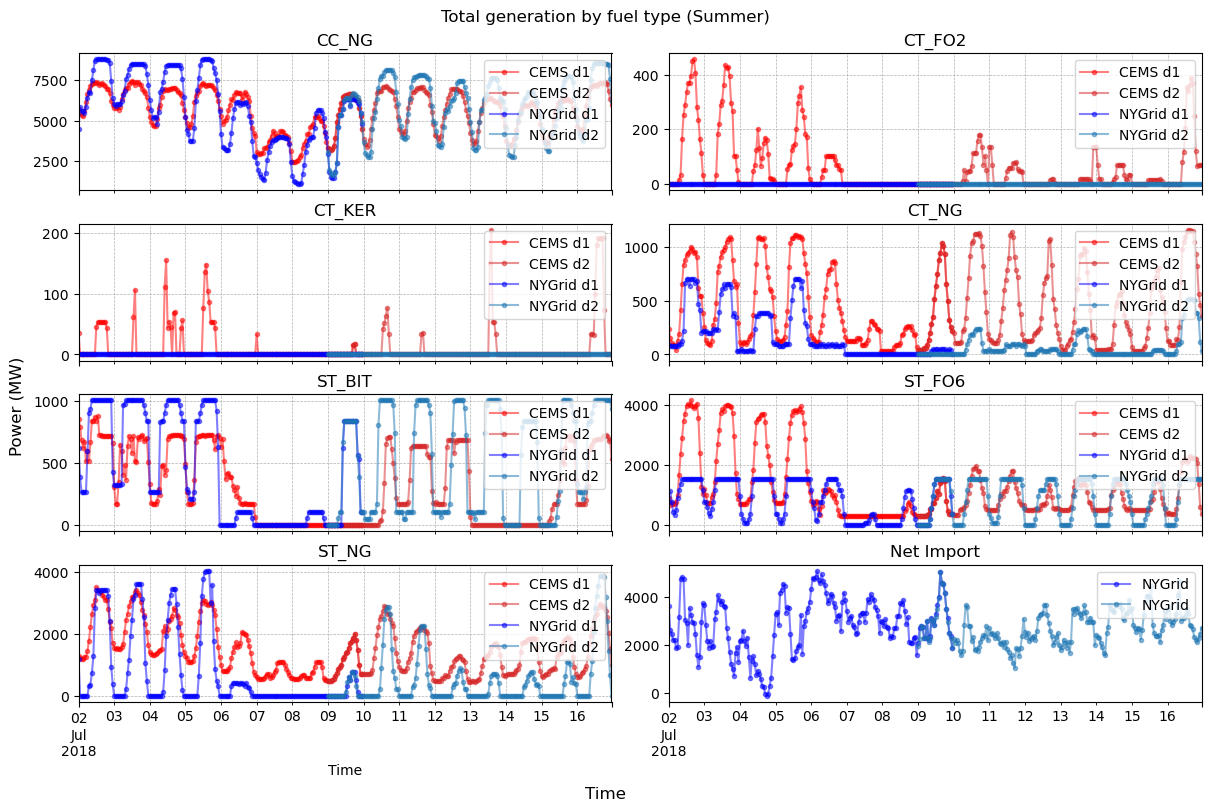

In [34]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8), sharex=True,
                        layout='constrained')

for i, fuel_type in enumerate(cems_gload_summary_s0.columns):
    ax = axs.flatten()[i]
    cems_gload_summary_s0[fuel_type].plot(ax=ax, alpha=0.5, color='red',
                                          label='CEMS d1', marker='.')
    cems_gload_summary_s1[fuel_type].plot(ax=ax, alpha=0.5, color='tab:red',
                                          label='CEMS d2', marker='.')
    pg_by_fuel_sum_s0[fuel_type].plot(ax=ax, alpha=0.5, color='blue',
                                      label='NYGrid d1', marker='.')
    pg_by_fuel_sum_s1[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue',
                                      label='NYGrid d2', marker='.')

    ax.set_title(fuel_type)
    ax.legend(loc='upper right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax = axs.flatten()[-1]
net_import_s0.plot(ax=ax, alpha=0.5, color='blue',
                   label='NYGrid', marker='.')
net_import_s1.plot(ax=ax, alpha=0.5, color='tab:blue',
                   label='NYGrid', marker='.')
ax.set_title('Net Import')
ax.legend(loc='upper right')

fig.supxlabel('Time')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type (Summer)')
plt.show()

### Unit commitment

In [35]:
n_thermal = nygrid_sim_w0.NG - nygrid_sim_w0.NESR - nygrid_sim_w0.NDCL*2
gen_pg = results_w0['PG'].iloc[:, :n_thermal]
gen_commit = results_w0['genCommit'].iloc[:, :n_thermal]
gen_startup = results_w0['genStartup'].iloc[:, :n_thermal]
gen_shutdown = results_w0['genShutdown'].iloc[:, :n_thermal]


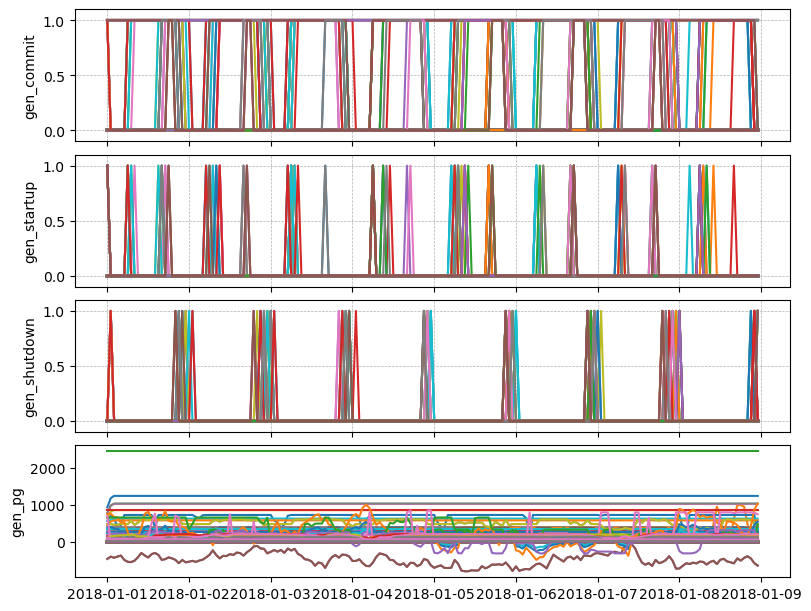

In [36]:
fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True, layout='constrained')
axs[0].plot(gen_commit, label='gen_commit')
axs[1].plot(gen_startup, label='gen_startup')
axs[2].plot(gen_shutdown, label='gen_shutdown')
axs[3].plot(gen_pg, label='gen_pg')
axs[0].set_ylabel('gen_commit')
axs[1].set_ylabel('gen_startup')
axs[2].set_ylabel('gen_shutdown')
axs[3].set_ylabel('gen_pg')
for ax in axs[:-1]:
    ax.set_ylim(-0.1, 1.1)
    ax.grid(linestyle='--', linewidth=0.5)
plt.show()

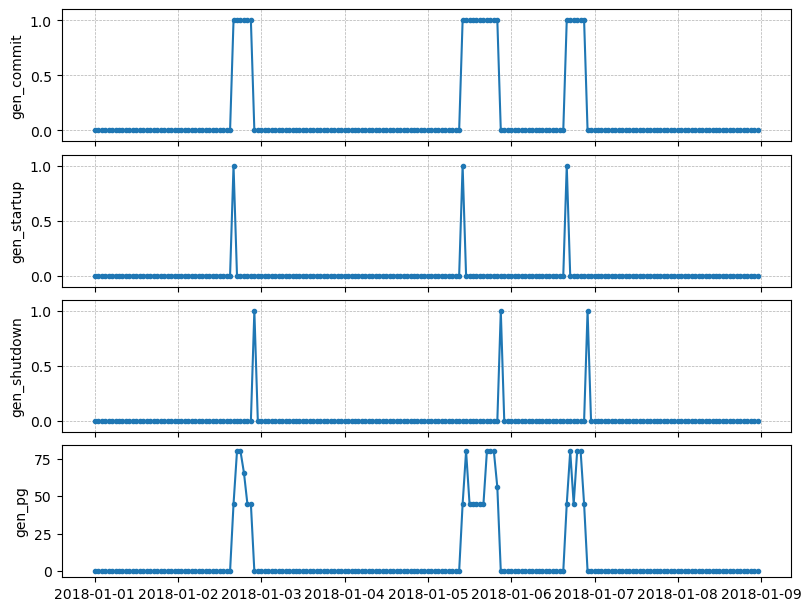

In [37]:
ii = 222

fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True, layout='constrained')
axs[0].plot(gen_commit[ii], marker='.', label='gen_commit')
axs[1].plot(gen_startup[ii], marker='.', label='gen_startup')
axs[2].plot(gen_shutdown[ii], marker='.', label='gen_shutdown')
axs[3].plot(gen_pg[ii], marker='.', label='gen_pg')
axs[0].set_ylabel('gen_commit')
axs[1].set_ylabel('gen_startup')
axs[2].set_ylabel('gen_shutdown')
axs[3].set_ylabel('gen_pg')
for ax in axs[:-1]:
    ax.set_ylim(-0.1, 1.1)
    ax.grid(linestyle='--', linewidth=0.5)
plt.show()

In [38]:
grid_prop['gen_prop'][['GEN_NAME', 'UNIT_TYPE', 'FUEL_TYPE', 'PMAX', 'MIN_UP_TIME', 'MIN_DOWN_TIME']].iloc[ii, :]

GEN_NAME         Pinelawn Power 1(56188,00001)
UNIT_TYPE                                   CC
FUEL_TYPE                                   NG
PMAX                                      80.0
MIN_UP_TIME                                  6
MIN_DOWN_TIME                                4
Name: 222, dtype: object

### Costs

In [39]:
print(f'Total cost: {results_w0["total_cost"].sum():.2f}')
print(f'Total penalty: {results_w0["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_w0["total_cost_penalty"].sum():.2f}')
print(f'Penalty percentage: {results_w0["total_penalty"].sum()/results_w0["total_cost"].sum()*100:.2f}%')

print(f'Gen cost: {results_w0["gen_cost"].sum():.2f}')
print(f'Gen no load cost: {results_w0["gen_cost_noload"].sum():.2f}')
print(f'Gen startup cost: {results_w0["gen_cost_startup"].sum():.2f}')
print(f'Gen shutdown cost: {results_w0["gen_cost_shutdown"].sum():.2f}')
print(f'ESR cost: {results_w0["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_w0["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_w0["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_w0["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_w0["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_w0["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_w0["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_w0["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_w0["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_w0["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_w0["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_w0["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_w0["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_w0["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_w0["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 47389829.29
Total penalty: 3537668.71
Total cost and penalty: 50927498.00
Penalty percentage: 7.47%
Gen cost: 47389805.23
Gen no load cost: 4083673.14
Gen startup cost: 703277.35
Gen shutdown cost: 0.00
ESR cost: 24.06
Over generation penalty: 0.00
Load shed penalty: 0.00
Ramp up penalty: 329218.45
Ramp down penalty: 2565.20
Interface max penalty: 150513.23
Interface min penalty: 3010171.83
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 37200.00


### ESR

In [40]:
# ii = 7
# crg_max = grid_prop['esr_prop']['ESR_CRG_MAX'].iloc[ii]
# dis_max = grid_prop['esr_prop']['ESR_DIS_MAX'].iloc[ii]
# crg_eff = grid_prop['esr_prop']['ESR_CRG_EFF'].iloc[ii]
# dis_eff = grid_prop['esr_prop']['ESR_DIS_EFF'].iloc[ii]
# soc_init = grid_prop['esr_prop']['ESR_SOC_INI'].iloc[ii]
# soc_max = grid_prop['esr_prop']['ESR_SOC_MAX'].iloc[ii]

# print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


In [41]:
# fig, axs = plt.subplots(3, 1, figsize=(10, 6),
#                        sharex=True, layout='constrained')

# results_0['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 1 w/o IC', alpha=0.5)
# results_0['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 1 w/o IC', alpha=0.5)
# results_0['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 1 w/o IC', alpha=0.5)

# # results_1['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 2 w/ IC', alpha=0.5)
# # results_1['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 2 w/ IC', alpha=0.5)
# # results_1['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 2 w/ IC', alpha=0.5)

# titles = ['Charge Power', 'Discharge Power', 'State of Charge']
# for i, ax in enumerate(axs):
#     ax.set_title(titles[i])